In [1]:
#ПАРАМЕТРЫ
configs = {
    'batch_size' : 32,     #размер батча
    'num_workers' : 4,     #количество процессов для загрузки датасета
    'lr' : 1e-4,             #learning rate
    'weight_decay' : 1e-4,   #
    'num_epochs' : 50,     #

    'augmentation': True,  #использовать ли аугментацию

    'train_ratio': 0.8,    #для обучения
    'val_ratio': 0.5,      #для валидации (от 1-train_ratio)
    'test_ratio': 0.5,     #для теста  (от 1-train_ratio)
}

In [2]:
#ИМПОРТ И ФУНКЦИИ С КЛАССАМИ
import os
import gc
import tqdm
import torch
import pickle
import random
import torchaudio
import numpy as np
import torch.nn as nn
from torch.utils.data import Subset
from matplotlib import pyplot as plt
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import SubsetRandomSampler
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score

class AudioAugmentation:
    def __init__(self, noise, shift):
        self.noise_factor = noise
        self.time_shift = shift
        
    def process(self, audio, size=256):
        if audio.shape[2] > size:
            start_pos = random.randint(0, audio.shape[2] - size)
            end_pos = start_pos + size
            audio = audio[:,:,start_pos:end_pos]

            # noise = torch.randn_like(audio) * self.noise_factor
            # audio = audio + noise

            # shift = int(audio.shape[2] * self.time_shift)
            # audio = torch.roll(audio, shift, 2)
        return audio

class SpectrogramDataset(Dataset):
    def __init__(self, dataset_path):
        with open(dataset_path, 'rb') as f:
            data = pickle.load(f)
        
        self.spectrograms = data['spectrograms']
        self.labels = data['labels']
        self.idx_to_genre = data['idx_to_genre']
        self.genre_to_idx = data['genre_to_idx']
        self.num_genres = len(self.idx_to_genre)
        self.augment = AudioAugmentation(0.01, 0.1)
    
    def __len__(self):
        return len(self.spectrograms)
    
    def __getitem__(self, idx):
        spectrogram = self.spectrograms[idx]
        label = self.labels[idx]

        label = torch.tensor(label, dtype=torch.int64)
        spectrogram = torch.from_numpy(spectrogram)
        
        if configs['augmentation']:
            spectrogram = self.augment.process(spectrogram)

        return spectrogram, label
    
    def get_genre_names(self):
        return list(self.genre_to_idx.keys())
    
    def _calculate_dataset_size(self):
        """Подсчитывает общий размер датасета в памяти"""
        total_size_bytes = 0
        
        # Размер спектрограмм
        if isinstance(self.spectrograms, torch.Tensor):
            total_size_bytes += self.spectrograms.element_size() * self.spectrograms.nelement()
        elif isinstance(self.spectrograms, np.ndarray):
            total_size_bytes += self.spectrograms.nbytes
        elif isinstance(self.spectrograms, list):
            # Если список тензоров/массивов
            for spec in self.spectrograms:
                if isinstance(spec, torch.Tensor):
                    total_size_bytes += spec.element_size() * spec.nelement()
                elif isinstance(spec, np.ndarray):
                    total_size_bytes += spec.nbytes
        
        # Размер меток
        if isinstance(self.labels, torch.Tensor):
            total_size_bytes += self.labels.element_size() * self.labels.nelement()
        elif isinstance(self.labels, np.ndarray):
            total_size_bytes += self.labels.nbytes
        elif isinstance(self.labels, list):
            # Примерно 8 байт на int в Python списке
            total_size_bytes += len(self.labels) * 8
        
        # Размер словарей
        import sys
        total_size_bytes += sys.getsizeof(self.idx_to_genre)
        total_size_bytes += sys.getsizeof(self.genre_to_idx)
        
        # Конвертируем в читаемый формат
        self.dataset_size_gb = total_size_bytes / (1024**3)
        self.dataset_size_mb = total_size_bytes / (1024**2)
        
        print(f"Размер датасета в памяти:")
        print(f"  {total_size_bytes:,} байт")
        print(f"  {self.dataset_size_mb:.2f} MB")
        print(f"  {self.dataset_size_gb:.2f} GB")
        
        # Дополнительная информация
        print(f"\nДетализация:")
        print(f"  Количество образцов: {len(self)}")
        if hasattr(self.spectrograms, 'shape'):
            print(f"  Форма спектрограмм: {self.spectrograms.shape}")
            print(f"  dtype спектрограмм: {self.spectrograms.dtype}")

class TinyFC(nn.Module):
    def __init__(self, num_classes, hidden=512):
        super(TinyFC, self).__init__()

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*256,hidden),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(hidden, num_classes)
        )

    def forward(self,x):
        return self.fc(x)
    
class TinyCNN(nn.Module):
    def __init__(self, num_classes, hidden=512, debug=False):
        super(TinyCNN, self).__init__()
        # вход - [batch, 1, 128, 256]
        
        self.debug = debug
        self.activations = {}
        
        # Block 1
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 16, 3, 1, 1),     
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        # Block 2
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, 3, 1, 1),     
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        # Block 3
        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, 3, 1, 1),     
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        # Block 4
        self.conv4 = nn.Sequential(
            nn.Conv2d(64, 128, 3, 1, 1),     
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(128, 256, 3, 1, 1),     
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.classifier = nn.Sequential(
            # nn.Flatten(),
            
            nn.Linear(256 * 4 * 8, hidden),
            nn.BatchNorm1d(hidden),
            nn.ReLU(),
            nn.Dropout(0.5),
            
            nn.Linear(hidden, hidden // 2),
            nn.BatchNorm1d(hidden // 2),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(hidden // 2, num_classes)
        )

        # self._init_weights()
                
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight, gain=1.0)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        if self.debug:
            self.activations['input'] = x.detach().cpu()
            
        x = self.conv1(x)
        if self.debug:
            self.activations['conv1'] = x.detach().cpu()

        x = self.conv2(x)
        if self.debug:
            self.activations['conv2'] = x.detach().cpu()

        x = self.conv3(x)
        if self.debug:
            self.activations['conv3'] = x.detach().cpu()

        x = self.conv4(x)
        if self.debug:
            self.activations['conv4'] = x.detach().cpu()

        x = self.conv5(x)
        if self.debug:
            self.activations['conv5'] = x.detach().cpu()

        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

def calculate_all_metrics(outputs, labels):
    if torch.is_tensor(outputs):
        outputs = outputs.detach().cpu().numpy()
    if torch.is_tensor(labels):
        labels = labels.detach().cpu().numpy()
    
    predicted = np.argmax(outputs, axis=1)

    accuracy = accuracy_score(labels, predicted)
    precision = precision_score(labels, predicted, average='macro', zero_division=0)
    recall = recall_score(labels, predicted, average='macro', zero_division=0)
    f1 = f1_score(labels, predicted, average='macro', zero_division=0)
    cm = confusion_matrix(labels, predicted)

    
    metrics = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'confusion_matrix': cm
    }
    
    return metrics

def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    all_outputs = []
    all_labels = []
    
    optimizer.zero_grad()

    for spectrograms, labels in dataloader:
        
        spectrograms = spectrograms.to(device)
        labels = labels.to(device)
        
        outputs = model(spectrograms)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        all_outputs.append(outputs.detach())
        all_labels.append(labels.detach())
    
    all_outputs = torch.cat(all_outputs)
    all_labels = torch.cat(all_labels)
    
    metrics = calculate_all_metrics(all_outputs, all_labels)
    avg_loss = running_loss / len(dataloader)
    
    return avg_loss, metrics

def evaluate_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_outputs = []
    all_labels = []
    
    with torch.no_grad():
        for spectrograms, labels in dataloader:

            # spectrograms = augmentation(spectrograms)

            spectrograms = spectrograms.to(device)
            labels = labels.to(device)
            
            outputs = model(spectrograms)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            all_outputs.append(outputs)
            all_labels.append(labels)
    
    all_outputs = torch.cat(all_outputs)
    all_labels = torch.cat(all_labels)
    
    metrics = calculate_all_metrics(all_outputs, all_labels)
    avg_loss = running_loss / len(dataloader)
    
    return avg_loss, metrics

def train_model(model, train_loader, val_loader, test_loader, optimizer, criterion, scheduler, patience=10, num_epochs=50, device='cuda', save_path='../data/models/genres/best_model.pth'):
    
    history = {
        'train_loss': [],
        'train_accuracy': [],
        'train_f1': [],
        'val_loss': [],
        'val_accuracy': [],
        'val_f1': []
    }
    
    best_val_accuracy = 0.0
    patience_counter = 0
    
    print(f"Используется устройство: {device}")
    param = sum(p.numel() for p in model.parameters())
    print(f"Количество параметров модели: {(param/1000000):.1f}M")
    
    # Главный прогресс-бар для эпох
    epoch_pbar = tqdm.tqdm(range(num_epochs), desc='Epochs')
    
    for epoch in epoch_pbar:
        
        if epoch > 20:
            optimizer.param_groups[0]['lr'] = 5e-5
        if epoch > 40:
            optimizer.param_groups[0]['lr'] = 1e-5

        # Обучение
        train_loss, train_metrics = train_epoch(model, train_loader, criterion, optimizer, device)
        
        # Валидация
        val_loss, val_metrics = evaluate_epoch(model, val_loader, criterion, device)
        
        # Валидация
        test_loss, test_metrics = evaluate_epoch(model, test_loader, criterion, device)
        # current_lr = optimizer.param_groups[0]['lr']
        
        # if scheduler is not None:
        #     if isinstance(scheduler, ReduceLROnPlateau):
        #         scheduler.step(val_loss)  # ReduceLROnPlateau использует val_loss
        #     else:
        #         scheduler.step()  # Другие schedulers обновляются каждый epoch

        # Сохраняем историю
        history['train_loss'].append(train_loss)
        history['train_accuracy'].append(train_metrics['accuracy'])
        history['train_f1'].append(train_metrics['f1_score'])
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_metrics['accuracy'])
        history['val_f1'].append(val_metrics['f1_score'])
        
        # Обновляем прогресс-бар эпохи
        epoch_pbar.set_postfix({
            'Train Loss': f'{train_loss:.4f}',
            'Train Acc': f'{train_metrics["accuracy"]:.4f}',
            'Val Acc': f'{val_metrics["accuracy"]:.4f}',
            'Best Val Acc': f'{best_val_accuracy:.4f}',
            'Test Acc': f'{test_metrics["accuracy"]:.4f}' 
        })
        
        # Ранняя остановка
        if val_metrics['accuracy'] > best_val_accuracy:
            best_val_accuracy = val_metrics['accuracy']
            patience_counter = 0
            torch.save(model.state_dict(), save_path)
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            print(f"\nРанняя остановка на эпохе {epoch+1}")
            break
    
    # Загружаем лучшую модель
    model.load_state_dict(torch.load(save_path))
    print(f"\nЛучшая точность на валидации: {best_val_accuracy:.4f}")
    
    return history, model

def load_model(model, model_path, device='cuda'):    
    # Загружаем веса
    model.load_state_dict(torch.load(model_path, map_location=device))

    print(f"Модель загружена из {model_path}")
    
    return model

def plot_training_history(history):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Loss
    axes[0, 0].plot(history['train_loss'], label='Train Loss', linewidth=2)
    axes[0, 0].plot(history['val_loss'], label='Val Loss', linewidth=2)
    axes[0, 0].set_title('Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Accuracy
    axes[0, 1].plot(history['train_accuracy'], label='Train Accuracy', linewidth=2)
    axes[0, 1].plot(history['val_accuracy'], label='Val Accuracy', linewidth=2)
    axes[0, 1].set_title('Accuracy')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # F1-Score
    axes[1, 0].plot(history['train_f1'], label='Train F1', linewidth=2)
    axes[1, 0].plot(history['val_f1'], label='Val F1', linewidth=2)
    axes[1, 0].set_title('F1-Score')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('F1-Score')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Сравнение метрик на последней эпохе
    metrics_names = ['Accuracy', 'F1-Score']
    train_metrics = [history['train_accuracy'][-1], history['train_f1'][-1]]
    val_metrics = [history['val_accuracy'][-1], history['val_f1'][-1]]
    
    x = np.arange(len(metrics_names))
    width = 0.35
    
    axes[1, 1].bar(x - width/2, train_metrics, width, label='Train', alpha=0.8)
    axes[1, 1].bar(x + width/2, val_metrics, width, label='Val', alpha=0.8)
    axes[1, 1].set_title('Final Metrics Comparison')
    axes[1, 1].set_xlabel('Metrics')
    axes[1, 1].set_ylabel('Score')
    axes[1, 1].set_xticks(x)
    axes[1, 1].set_xticklabels(metrics_names)
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    # Добавляем значения на столбцы
    for i, v in enumerate(train_metrics):
        axes[1, 1].text(i - width/2, v + 0.01, f'{v:.3f}', ha='center', va='bottom')
    for i, v in enumerate(val_metrics):
        axes[1, 1].text(i + width/2, v + 0.01, f'{v:.3f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    # Выводим числовые результаты
    print("\nФИНАЛЬНЫЕ РЕЗУЛЬТАТЫ:")
    print(f"Train Loss: {history['train_loss'][-1]:.4f}")
    print(f"Val Loss: {history['val_loss'][-1]:.4f}")
    print(f"Train Accuracy: {history['train_accuracy'][-1]:.4f}")
    print(f"Val Accuracy: {history['val_accuracy'][-1]:.4f}")
    print(f"Train F1-Score: {history['train_f1'][-1]:.4f}")
    print(f"Val F1-Score: {history['val_f1'][-1]:.4f}")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  

In [3]:
# #ЗАГРУЗКА ДАТАСЕТА
dataset = SpectrogramDataset("/home/egr/projects/nmus/data/datasets/genres_dataset.pkl")
# dataset._calculate_dataset_size()

# разбиваем датасет на train и test
dataset_size = len(dataset)
indices = list(range(dataset_size))

#для обучения
train_idx, temp_idx = train_test_split(
    indices,
    train_size=configs['train_ratio'],
    test_size=1-configs['train_ratio'],
    # stratify=dataset.labels,
    random_state=42
)
    
#для валидации и теста
val_idx, test_idx = train_test_split(
    temp_idx,
    test_size=configs['test_ratio'],
    # stratify=[dataset.labels[i] for i in temp_idx]
)

train_dataset = Subset(dataset, train_idx)
val_dataset = Subset(dataset, val_idx)
test_dataset = Subset(dataset, test_idx)

train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,  
    num_workers=4,   
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=2
)

val_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,  
    num_workers=2,   
    pin_memory=True,
    persistent_workers=False,
    prefetch_factor=2
)

test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,  
    num_workers=2,   
    pin_memory=True,
    persistent_workers=False,
    prefetch_factor=2
)

def check_data_shapes(loader, name):
    # Проверяем train loader
    print(f"{name}: ")
    for spectrograms, labels in loader:
        print(f"  Length loader: {len(loader)}")
        print(f"  Spectrograms: {spectrograms.shape}")
        print(f"  Labels: {labels.shape}")              
        a = labels.tolist()[0]
        print(f"  Example label: {a}-{dataset.idx_to_genre[a]}\n")
        break

print(f"Проверка размерностей данных (batch_size={configs['batch_size']}):\n")
check_data_shapes(train_loader, "Train_loader")
check_data_shapes(val_loader, "Val_loader")
# check_data_shapes(test_loader, "Test_loader")

print(f"GPU Memory allocated: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")
print(f"GPU Memory cached: {torch.cuda.memory_reserved() / 1024**3:.2f} GB")

Проверка размерностей данных (batch_size=32):

Train_loader: 
  Length loader: 25
  Spectrograms: torch.Size([32, 1, 128, 256])
  Labels: torch.Size([32])
  Example label: 5-jazz

Val_loader: 
  Length loader: 4
  Spectrograms: torch.Size([32, 1, 128, 256])
  Labels: torch.Size([32])
  Example label: 0-blues

GPU Memory allocated: 0.00 GB
GPU Memory cached: 0.00 GB


{np.int64(3): 100, np.int64(8): 100, np.int64(9): 100, np.int64(4): 100, np.int64(2): 100, np.int64(0): 100, np.int64(1): 100, np.int64(7): 100, np.int64(6): 100, np.int64(5): 99}
Используется устройство: cuda
Количество параметров модели: 4.7M


Epochs: 100%|██████████| 50/50 [00:45<00:00,  1.11it/s, Train Loss=0.4519, Train Acc=0.8611, Val Acc=0.7400, Best Val Acc=0.8200, Test Acc=0.7300]



Лучшая точность на валидации: 0.8200


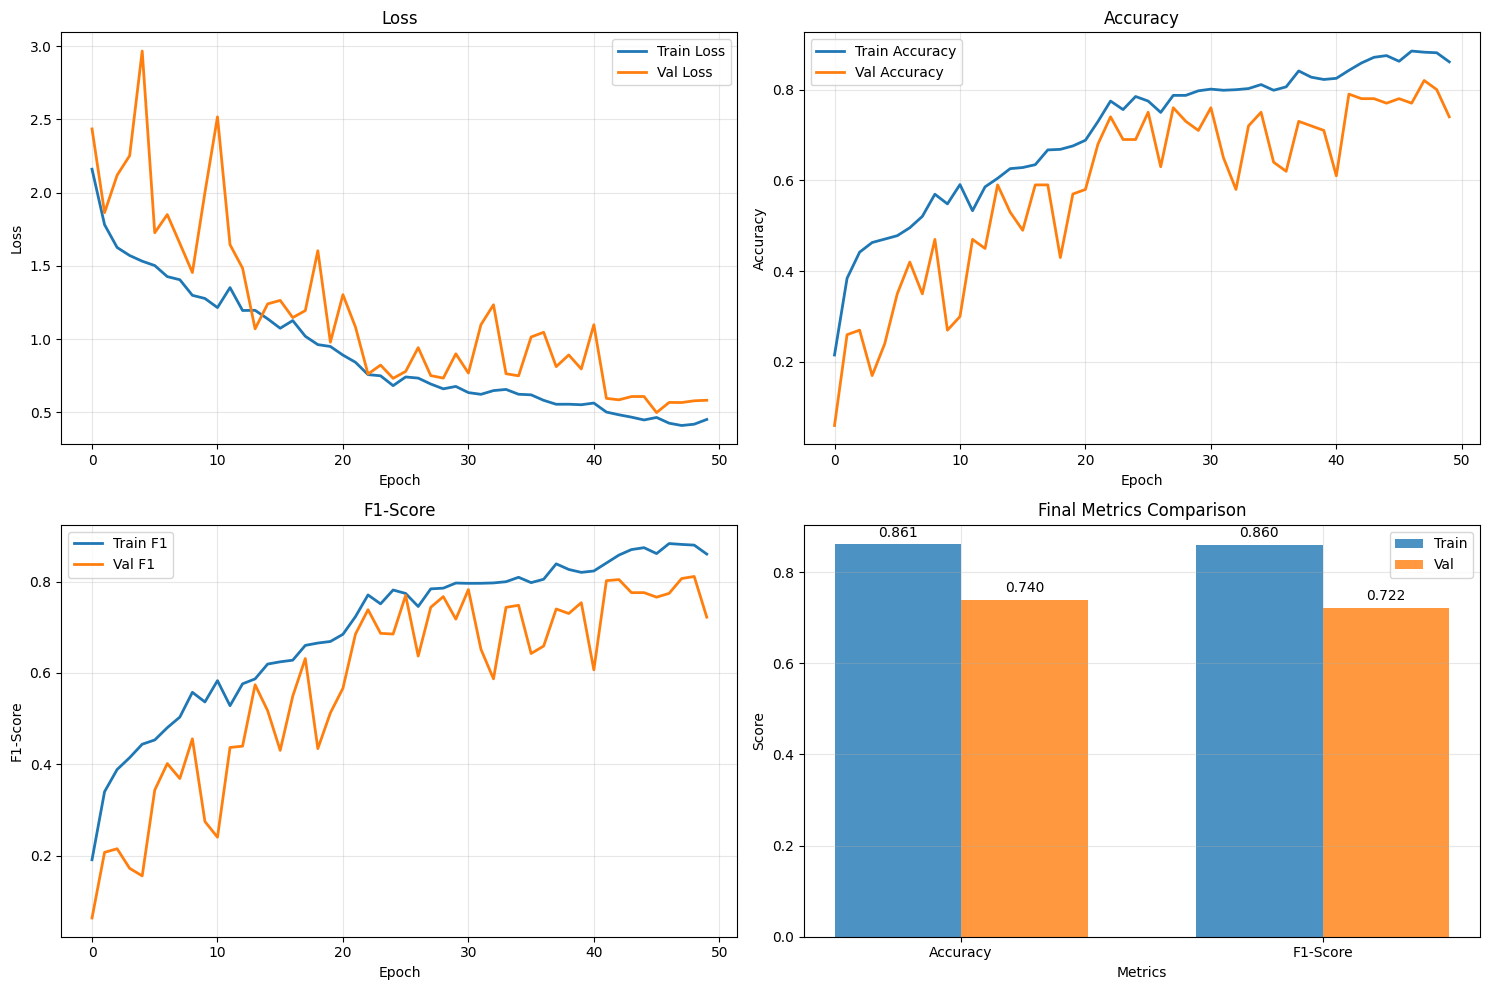


ФИНАЛЬНЫЕ РЕЗУЛЬТАТЫ:
Train Loss: 0.4519
Val Loss: 0.5829
Train Accuracy: 0.8611
Val Accuracy: 0.7400
Train F1-Score: 0.8601
Val F1-Score: 0.7220


In [ ]:
#ОБУЧЕНИЕ МОДЕЛИ
num_epochs = 50            # количество эпох для обучения
patience = 20              # остановка обучения после N эпох без улучшений

def labels_check(dataset):
    all_targets = []
    for i in range(len(dataset)):
        _, targets = dataset[i]
        all_targets.append(targets)

    dict_tag = {}
    all_targets = torch.stack(all_targets).cpu().numpy()
    for target in all_targets:
        dict_tag.setdefault(target, 0)
        dict_tag[target] += 1
    print(dict_tag)

labels_check(dataset)

model = TinyCNN(dataset.num_genres)
# model = load_model(model, "/home/egr/projects/nmus/data/models/genres/best_model.pth", device)
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()

history, trained_model = train_model(
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    scheduler=None,
    num_epochs=num_epochs,
    patience=patience,
    device=device,
    save_path="/home/egr/projects/nmus/data/models/genres/best_model.pth"
)

plot_training_history(history)

Модель загружена из /home/egr/projects/nmus/data/models/genres/best_model.pth
torch.Size([16, 64, 128])


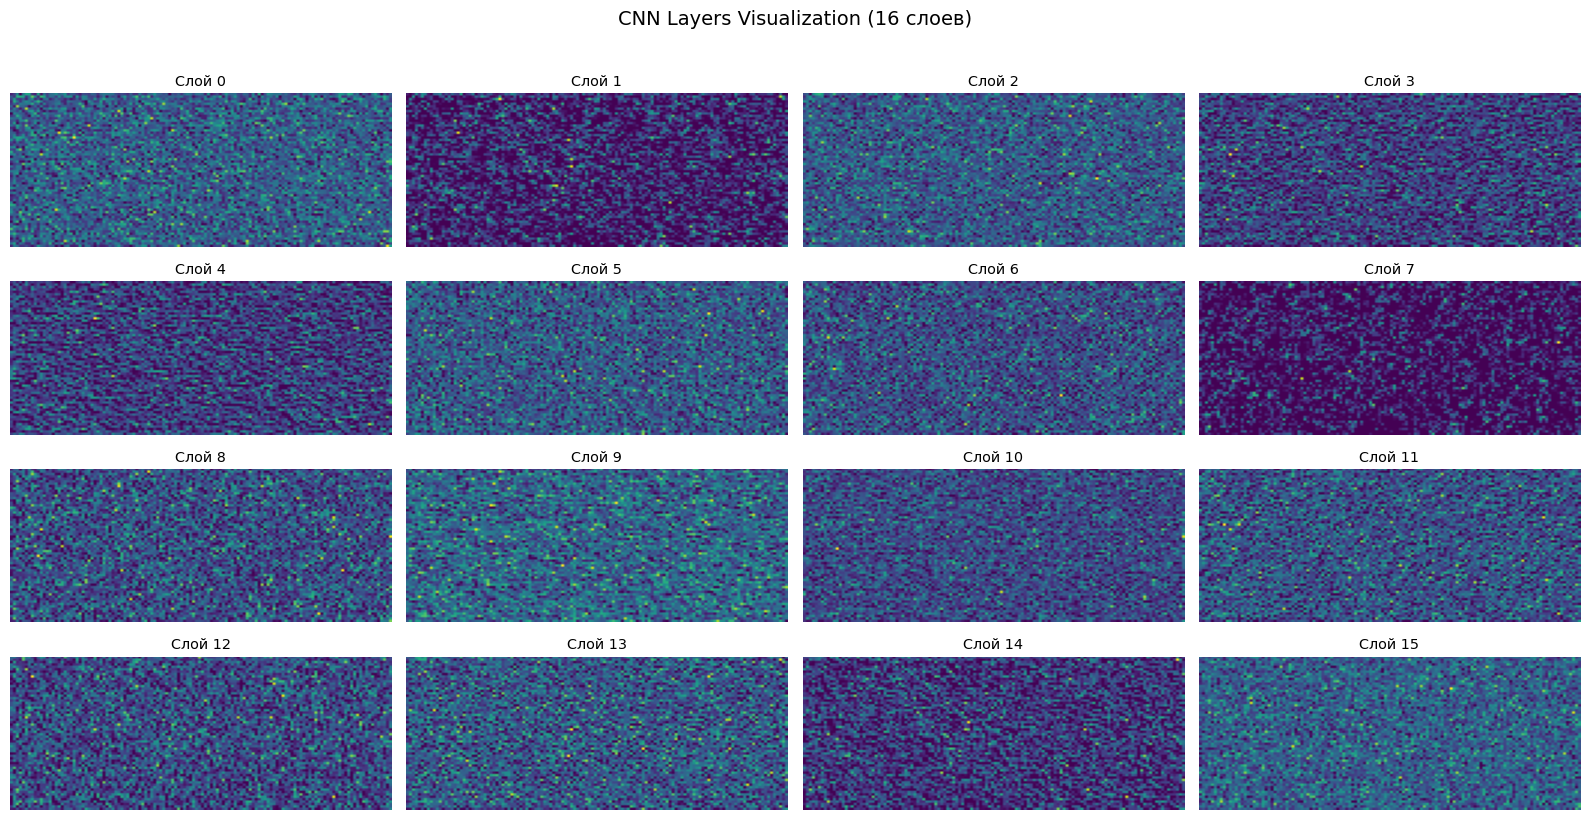

torch.Size([32, 32, 64])


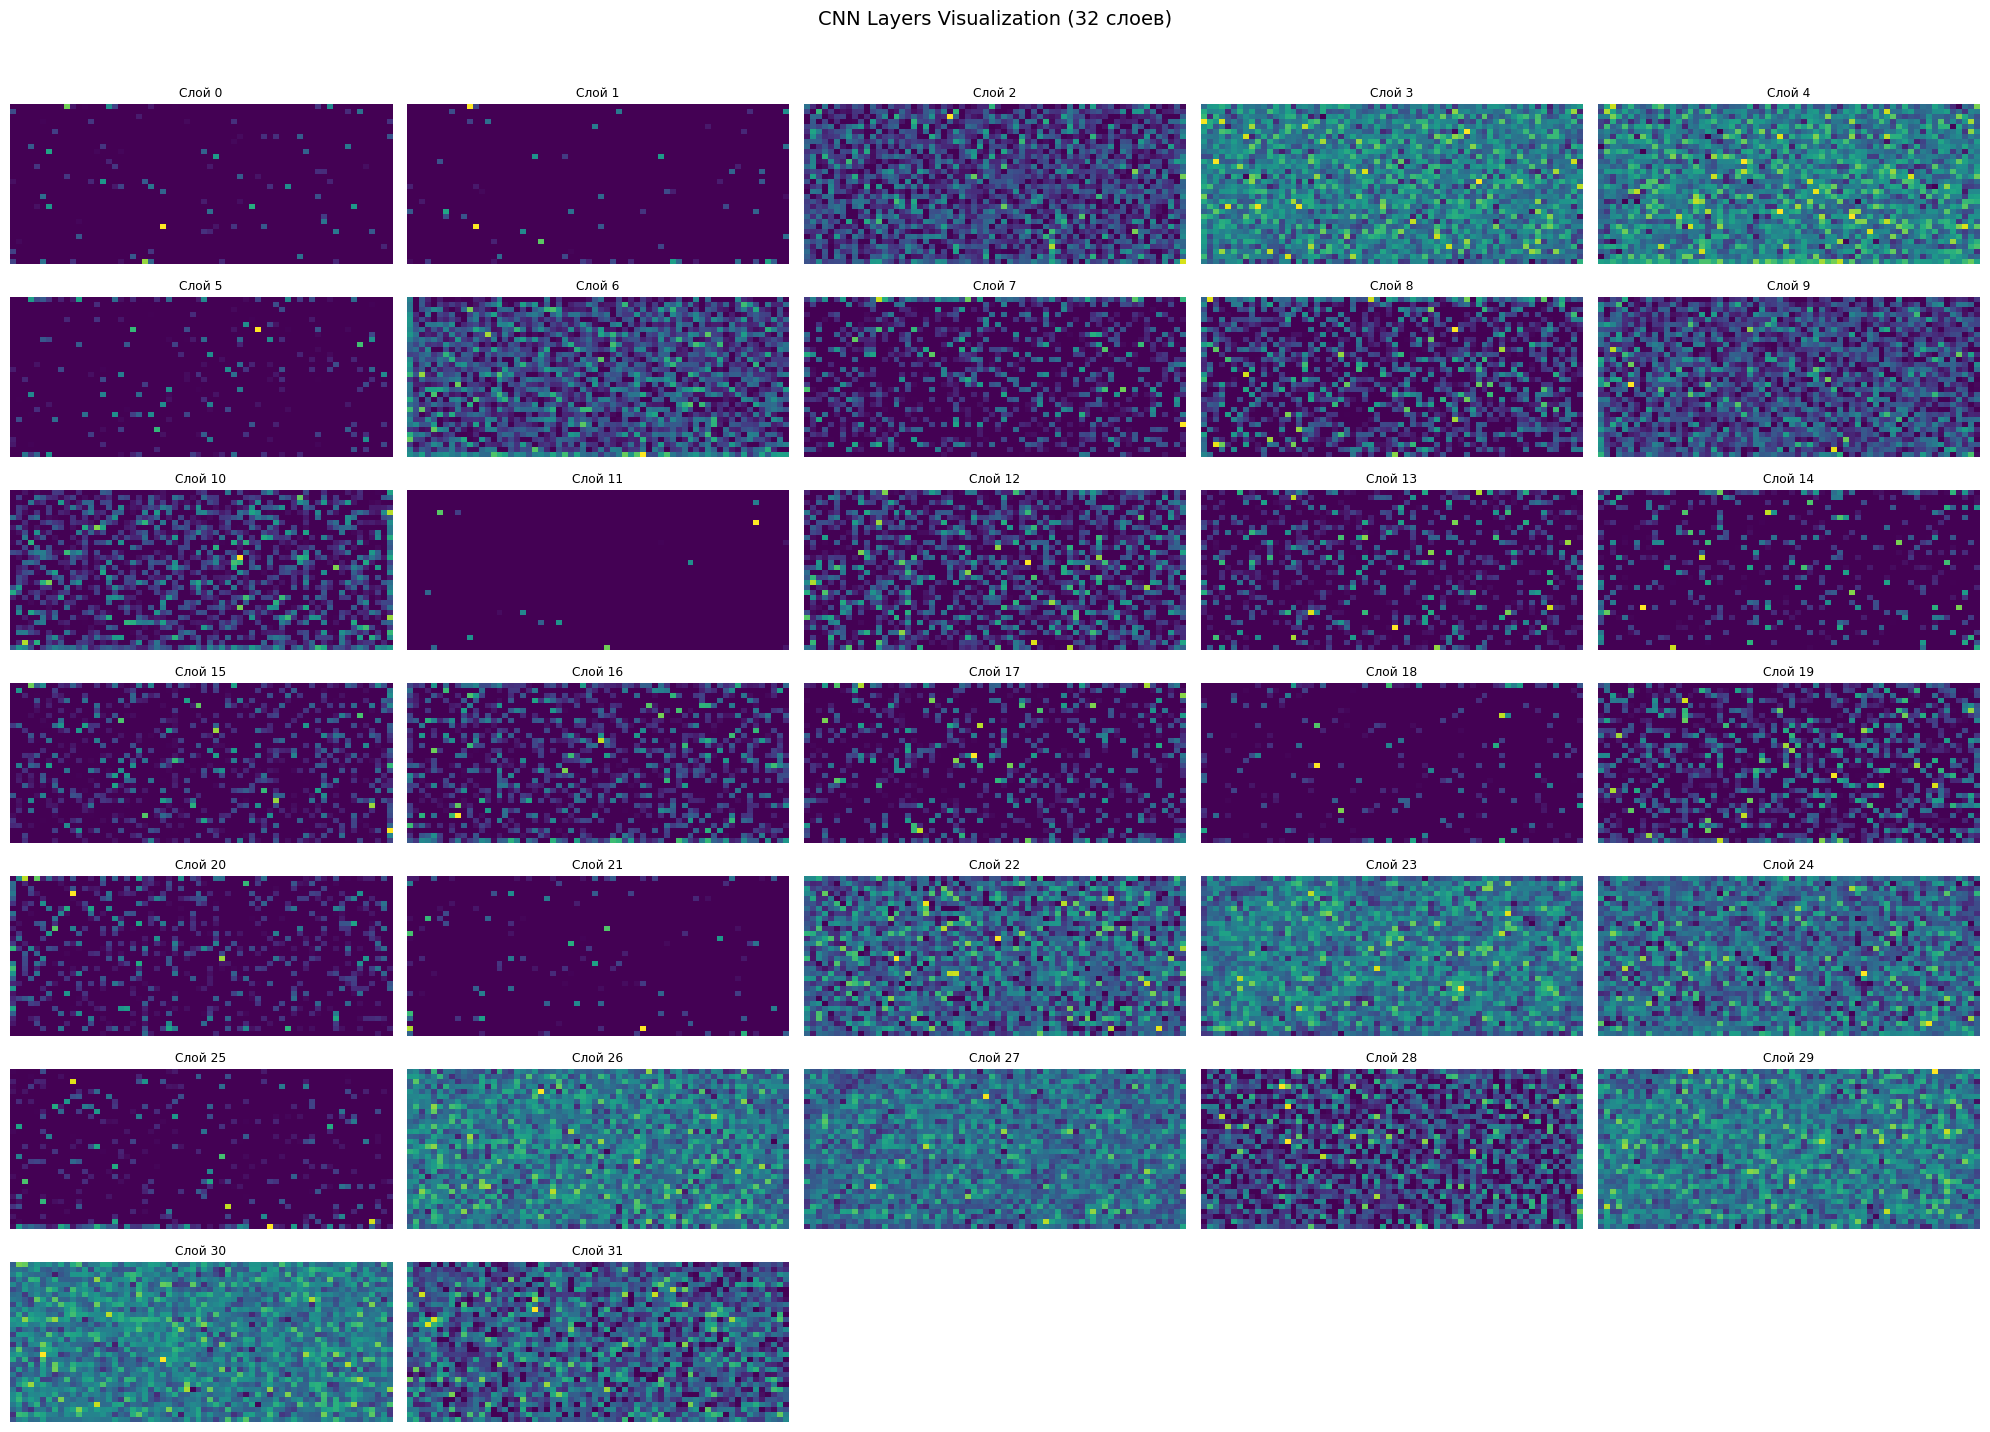

torch.Size([64, 16, 32])


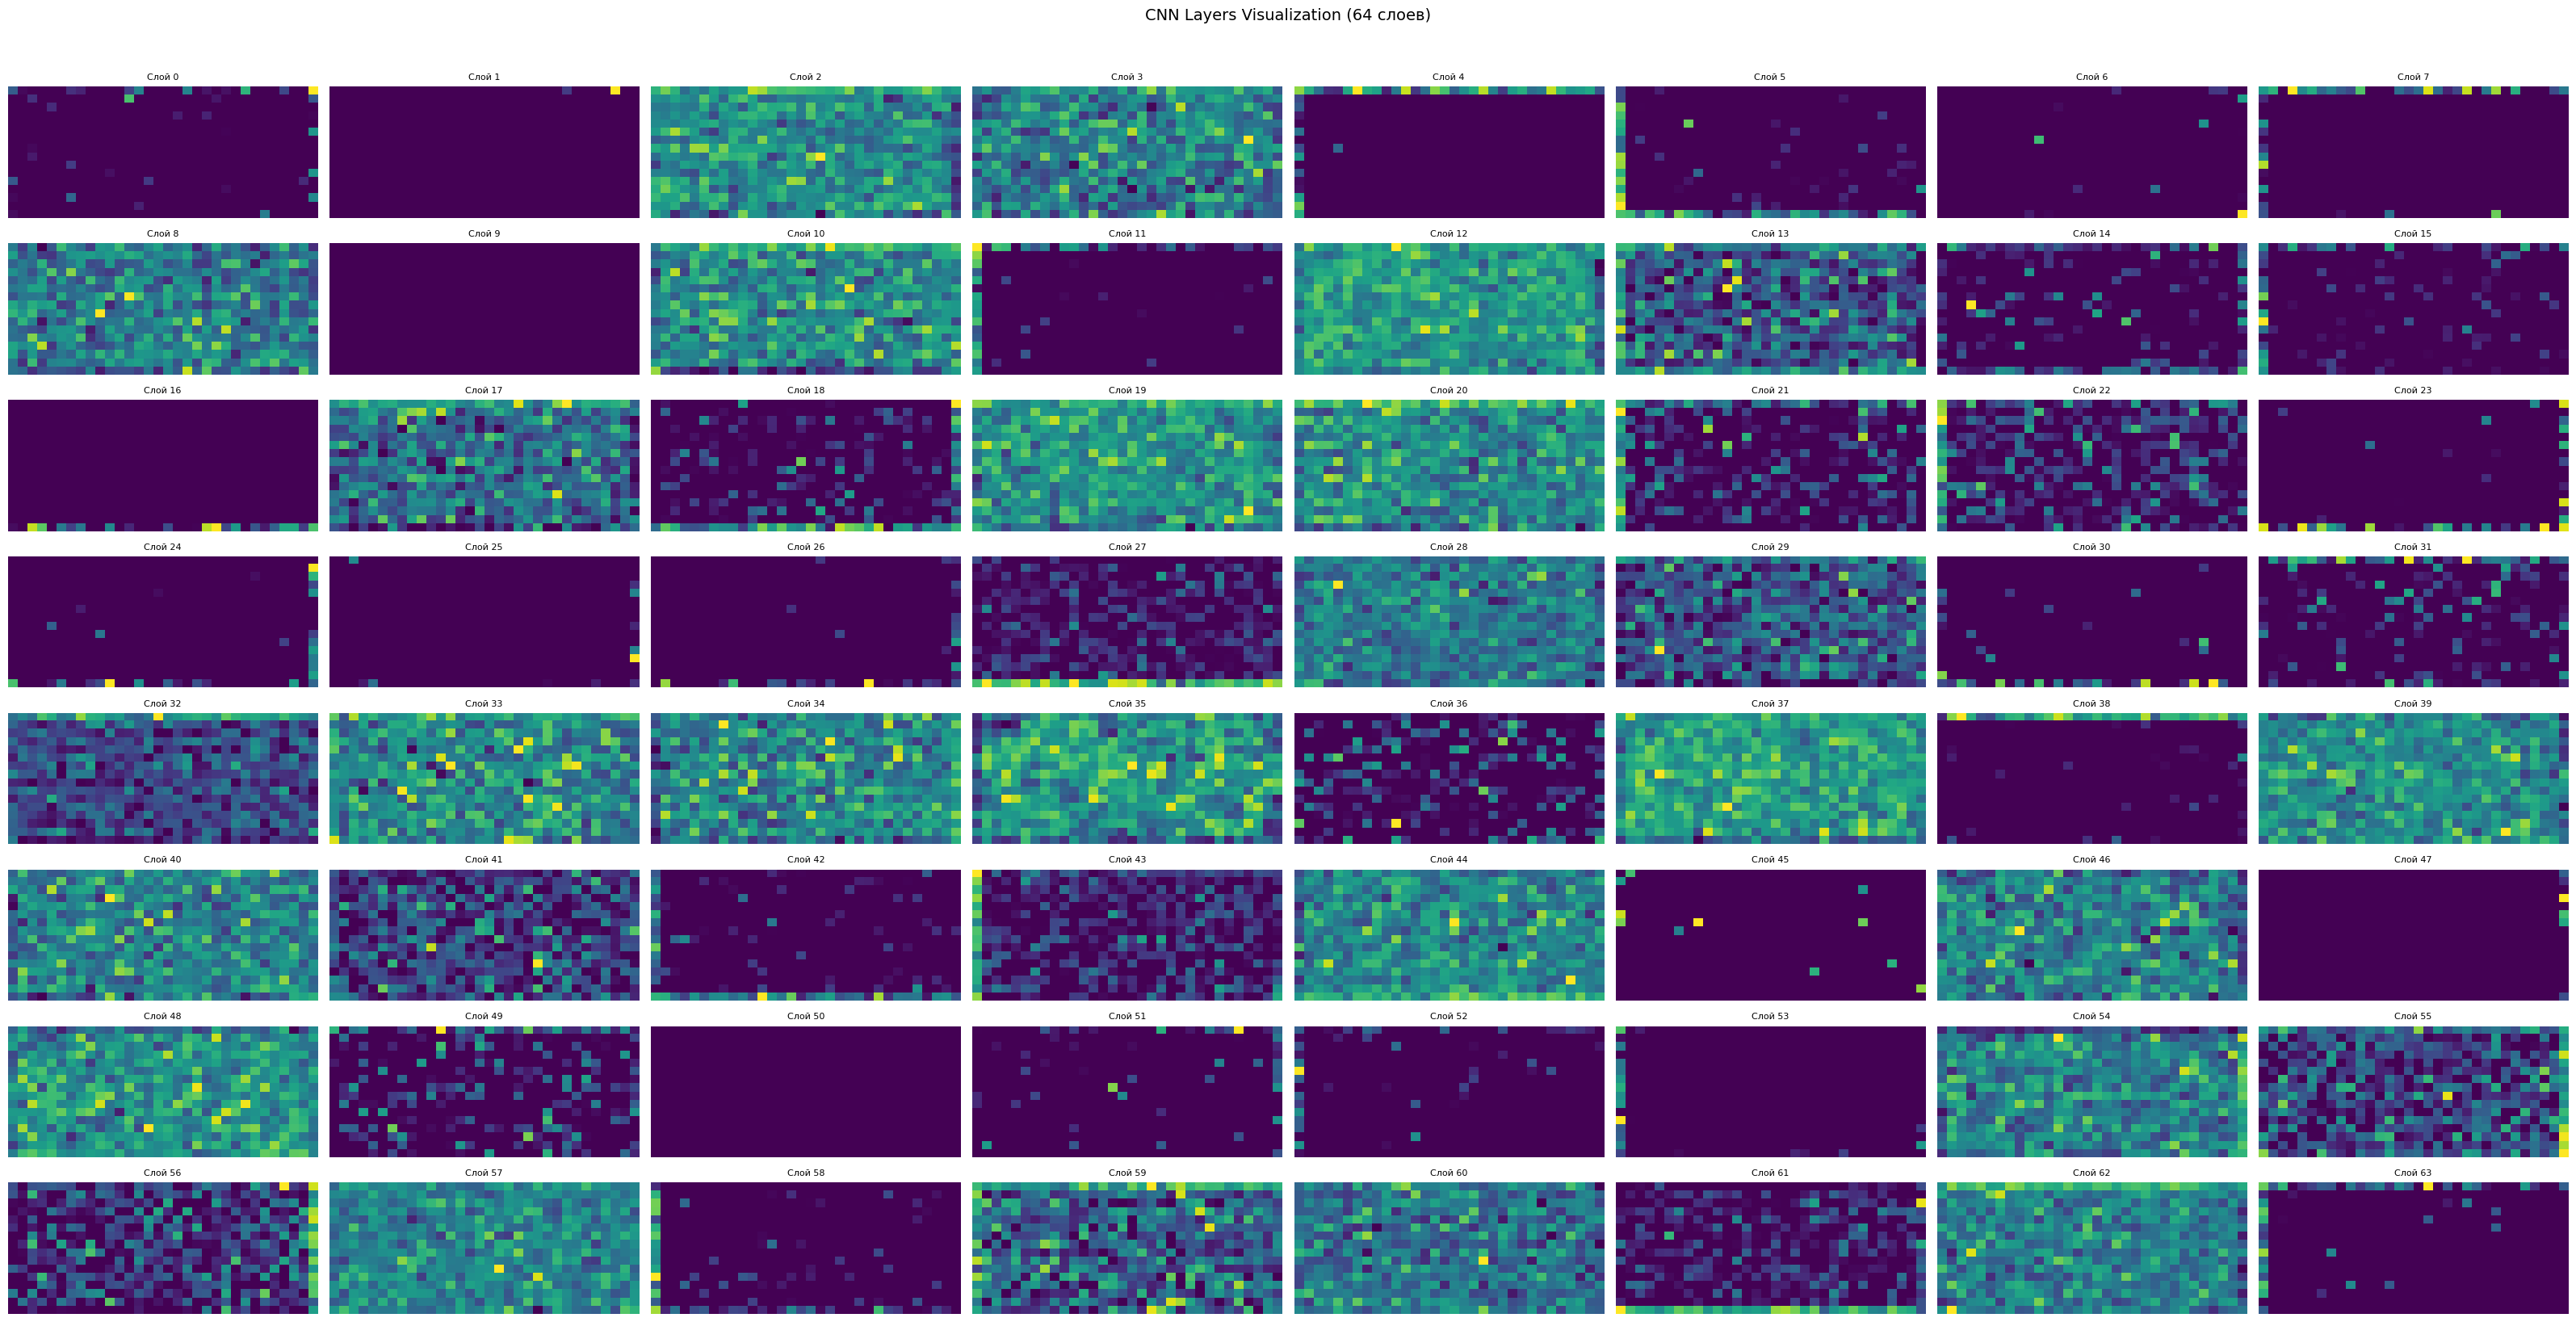

torch.Size([128, 8, 16])


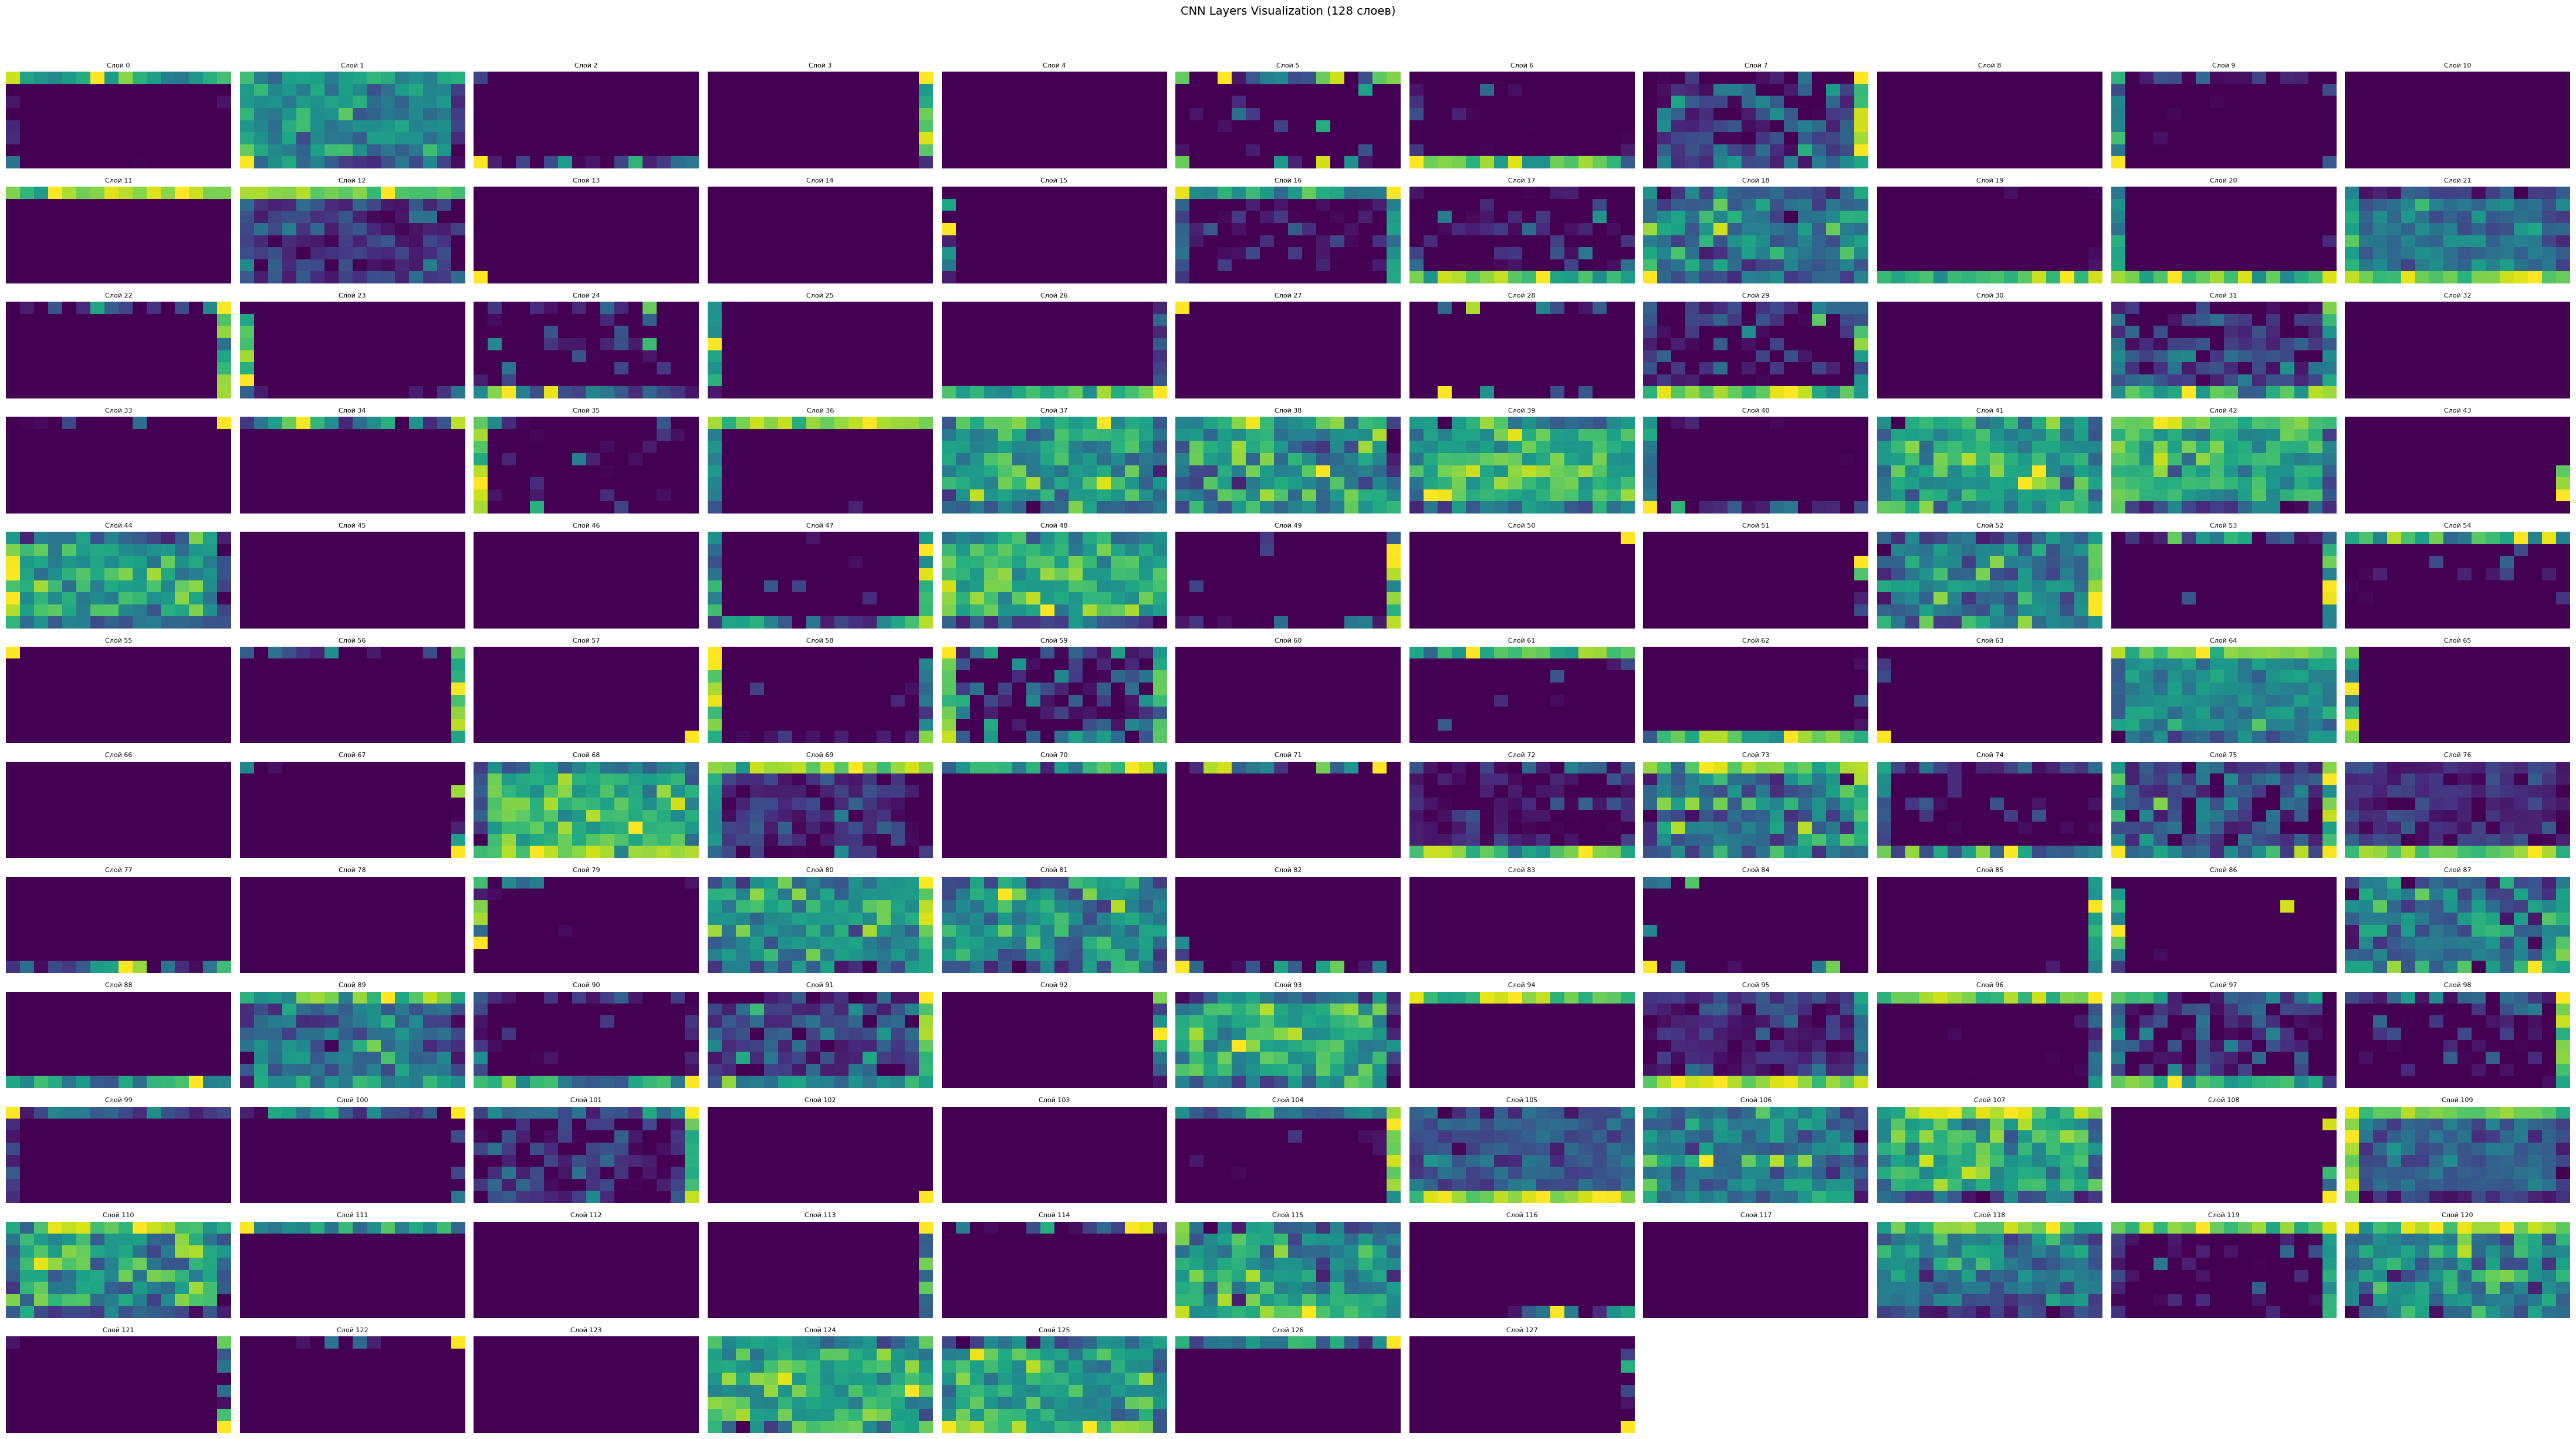

torch.Size([256, 4, 8])


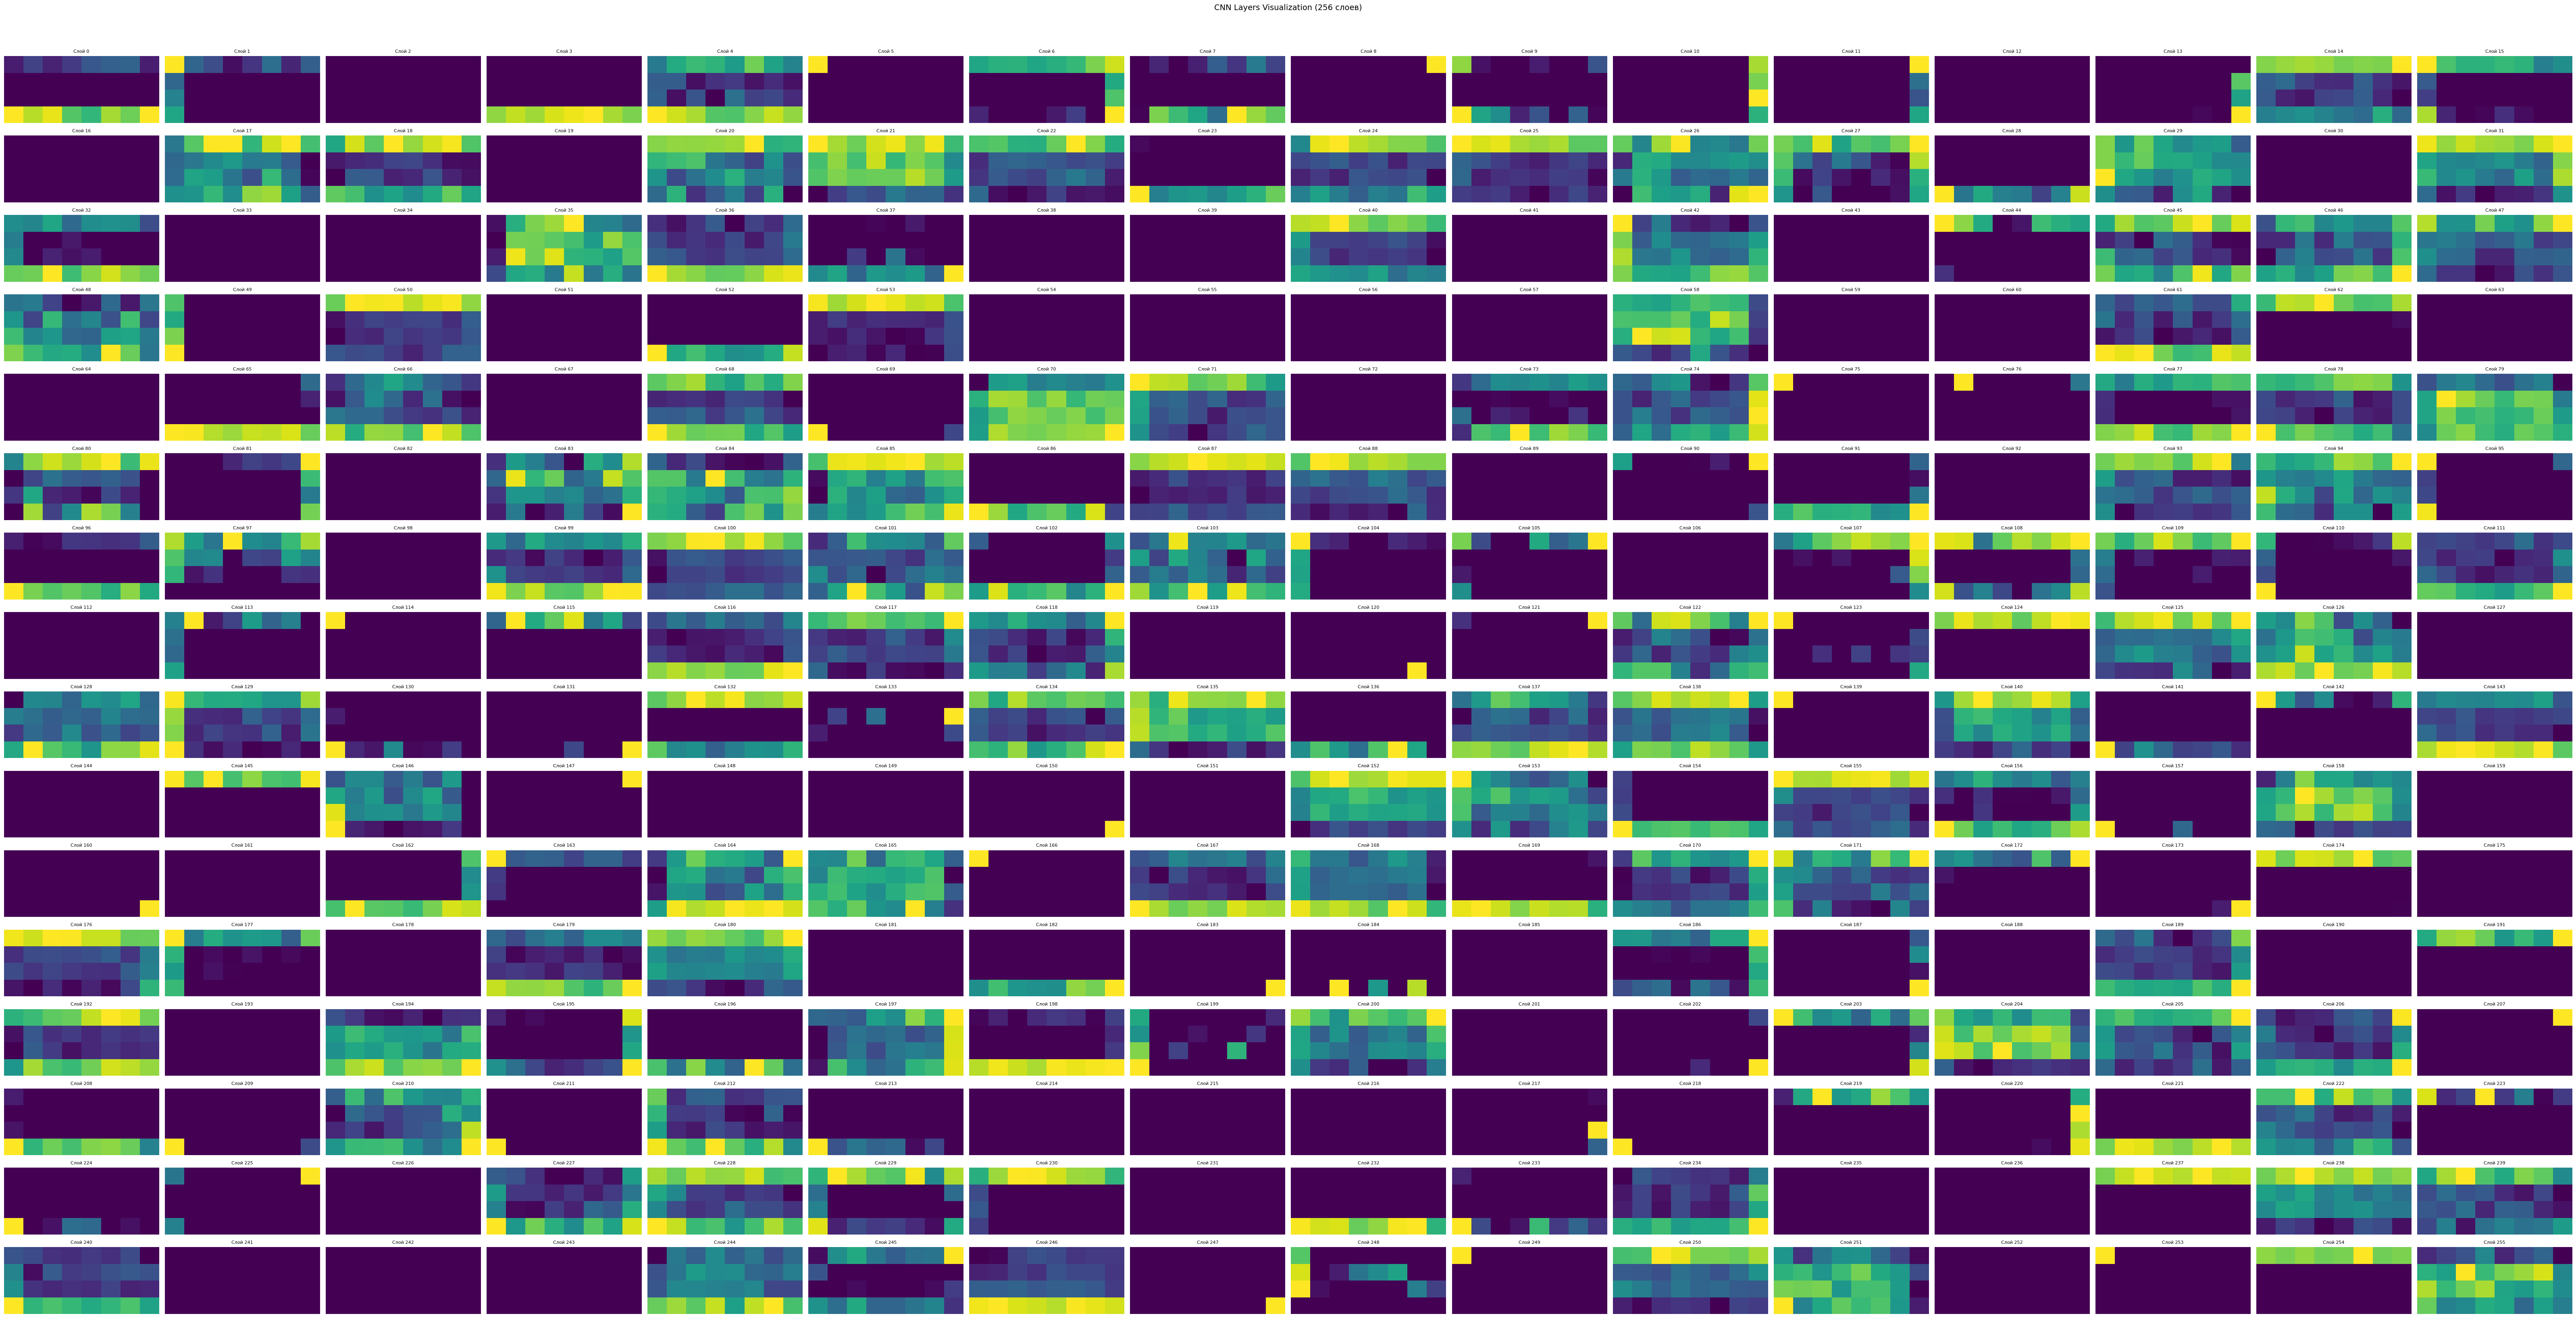

tensor([[0.0000e+00, 5.2409e-41, 0.0000e+00, 1.5395e-33, 0.0000e+00, 1.7096e-43,
         1.0000e+00, 2.1105e-27, 0.0000e+00, 0.0000e+00]], device='cuda:0')
tensor([6], device='cuda:0')


In [9]:
import math
from torch import argmax, softmax
import torchaudio

def create_spectrogram(audio_path, sample_rate=16000, n_fft=512, hop_length=256, n_mels=128):
    try:
        # Загружаем аудиофайл
        waveform, original_sample_rate = torchaudio.load(audio_path)

        # Преобразуем к моно если нужно
        if waveform.shape[0] > 1:
            waveform = torch.mean(waveform, dim=0, keepdim=True)
        
        # Ресемплируем если необходимо
        if original_sample_rate != sample_rate:
            resampler = torchaudio.transforms.Resample(original_sample_rate, sample_rate)
            waveform = resampler(waveform)
        
        # Создаем mel-спектрограмму
        mel_spectrogram = torchaudio.transforms.MelSpectrogram(
            sample_rate=sample_rate,
            n_fft=n_fft,
            hop_length=hop_length,
            n_mels=n_mels
        )

        # Применяем преобразование
        spectrogram = mel_spectrogram(waveform)
        
        # Применяем логарифмическое преобразование для лучшего восприятия
        spectrogram = torchaudio.functional.amplitude_to_DB(
            spectrogram, 
            multiplier=10, 
            amin=1e-10, 
            db_multiplier=0, 
            top_db=80.0
        )
        
        # Нормализуем спектрограмму
        spectrogram = (spectrogram - spectrogram.mean()) / (spectrogram.std() + 1e-8)
    except Exception as e:
        print(f"Ошибка при обработке {audio_path}: {e}")
        return torch.zeros((1,1,1))

    return spectrogram

def spektr_view(mel_spektr, w=16, h=8):
    plt.figure(figsize=(w, h))
    plt.imshow(mel_spektr[:,:], cmap='viridis', origin='lower', aspect='auto')
    plt.colorbar(label='Громкость (dB)')
    plt.title("Mel-спектрограмма")
    plt.xlabel("Время (кадры)")
    plt.ylabel("Mel-банки")
    plt.show()

def cnn_view(layers, cmap='viridis', max_cols=8, figsize_mult=2):
    layers = layers.squeeze(0)
    num_layers = layers.shape[0]

    cols = int(max(math.sqrt(layers.shape[0]), max_cols))
    rows = math.ceil(num_layers / cols)
    
    # Автоматически определяем размеры сетки
    # cols = min(max_cols, num_layers)  # Не больше max_cols столбцов
    # rows = math.ceil(num_layers / cols)  # Столько строк, сколько нужно
    
    # Рассчитываем размер фигуры
    fig_width = cols * figsize_mult * (layers.shape[2] / layers.shape[1])
    fig_height = rows * figsize_mult
    
    fig, axes = plt.subplots(rows, cols, figsize=(fig_width, fig_height))
    
    # Преобразуем axes в плоский массив для удобства
    if rows == 1 and cols == 1:
        axes = np.array([axes])
    elif rows == 1 or cols == 1:
        axes = axes.flat
    else:
        axes = axes.flat
    

    print(layers.shape)

    for i in range(num_layers):
        # Нормализуем каждый слой для лучшей визуализации
        layer = layers[i]
        if layer.max() - layer.min() > 0:
            layer_norm = (layer - layer.min()) / (layer.max() - layer.min())
        else:
            layer_norm = layer
        axes[i].imshow(layer_norm, cmap=cmap, aspect='auto', origin='lower')
        axes[i].set_title(f'Слой {i}', fontsize=max(8, 12 - 0.1 * num_layers))
        axes[i].axis('off')
    
    # Скрываем пустые subplots
    for j in range(num_layers, len(axes)):
        axes[j].axis('off')
    
    plt.suptitle(f'CNN Layers Visualization ({num_layers} слоев)', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()

model = TinyCNN(num_classes=10)
load_path = "/home/egr/projects/nmus/data/models/genres/best_model.pth"
model = load_model(model, load_path, device)
model.debug = True
model.to(device)

# path = "/home/egr/projects/nmus/data/genres/"
# batch = torch.zeros((1000,1,128,256))
# k = 0
# for i in range(0,10):
#     audiopath = path + str(dataset.idx_to_genre[i]) + "."
#     print(audiopath)
#     for j in range(0,100):
#         spec = create_spectrogram(audiopath + str(i).zfill(5) + ".wav")
#         if spec.shape[2] != 1: batch[k] = spec[:,:,:256]
#         k += 1

# batch = batch.to(device)
# i = 10
# audiopath = path + str(dataset.idx_to_genre[i]) + "."
# spec = create_spectrogram(audiopath + str(i).zfill(5) + ".wav")

input_tensor = (20 * torch.randn(1,1,128,256) - 10).to(device)
# Предсказание
with torch.no_grad():
    model.eval()
    outputs = model(input_tensor)

# print(f"input_min: {mel_spec.min()}")
# print(f"input_max: {mel_spec.max()}")
# print(f"input_mean: {mel_spec.mean()}")
# conv1 = model.activations['conv1']
# conv2 = model.activations['conv2']
# conv3 = model.activations['conv3']
# conv4 = model.activations['conv4']
# conv5 = model.activations['conv5']
# print(f"conv1.min: {conv1.min():.4f} | conv1.max: {conv1.max():.4f} | conv1.mean: {conv1.mean():.4f}")
# print(f"conv2.min: {conv2.min():.4f} | conv2.max: {conv2.max():.4f} | conv2.mean: {conv2.mean():.4f}")
# print(f"conv3.min: {conv3.min():.4f} | conv3.max: {conv3.max():.4f} | conv3.mean: {conv3.mean():.4f}")
# print(f"conv4.min: {conv4.min():.4f} | conv4.max: {conv4.max():.4f} | conv4.mean: {conv4.mean():.4f}")
# print(f"conv5.min: {conv5.min():.4f} | conv5.max: {conv5.max():.4f} | conv5.mean: {conv5.mean():.4f}")
# print(f"outputs.min: {outputs.min():.4f} | outputs.max: {outputs.max():.4f} | outputs.mean: {outputs.mean():.4f}")
# # print(f"outputs: {outputs}")

# probs = softmax(outputs, dim=1) 
# pred_class = torch.argmax(probs).item()
# print(f"Предсказанный класс: {pred_class}-{dataset.idx_to_genre[pred_class]}")
# print(f"Вероятности: probs.min={probs.min().item()} | probs.max={probs.max().item()} | probs.mean={probs.mean().item()}")

#отображение выхода cnn слоёв
cnn_view(model.activations['conv1'], "viridis", 4, figsize_mult=2)
cnn_view(model.activations['conv2'], "viridis", 4, figsize_mult=2)
cnn_view(model.activations['conv3'], "viridis", 4, figsize_mult=2)
cnn_view(model.activations['conv4'], "viridis", 4, figsize_mult=2)
cnn_view(model.activations['conv5'], "viridis", 4, figsize_mult=2)

#вывод вероятностей
probs = softmax(outputs, dim=1)
pred_classes = argmax(outputs, axis=1)
print(probs)
print(pred_classes)
# print(f"Batch size: {outputs.shape[0]}")
# print(f"Number of classes: {outputs.shape[1]}")
# print(f"Predicted classes shape: {pred_classes.shape}")

# # Вариант 1: Вывести все предсказания
# print("\n=== ВСЕ ПРЕДСКАЗАНИЯ ===")
# for i in range(len(pred_classes)):
#     pred_class = pred_classes[i].item()
#     genre = dataset.idx_to_genre[pred_class]
    
#     # Вероятность для предсказанного класса
#     confidence = probs[i, pred_class].item()
    
#     print(f"Пример {i:3d}: класс {pred_class}-{genre:15} уверенность: {confidence:.2%}")

# # Вариант 2: Вывести статистику
# print("\n=== СТАТИСТИКА ===")
# print(f"Минимальная вероятность в батче: {probs.min().item():.4%}")
# print(f"Максимальная вероятность в батче: {probs.max().item():.4%}")
# print(f"Средняя вероятность в батче: {probs.mean().item():.4%}")

# # Статистика по уверенности предсказаний
# confidences = probs[torch.arange(len(pred_classes)), pred_classes]
# print(f"\nУверенность предсказаний:")
# print(f"  Средняя уверенность: {confidences.mean().item():.2%}")
# print(f"  Минимальная уверенность: {confidences.min().item():.2%}")
# print(f"  Максимальная уверенность: {confidences.max().item():.2%}")

# # Распределение классов
# print(f"\nРаспределение предсказанных классов:")
# unique_classes, counts = torch.unique(pred_classes, return_counts=True)
# for cls, count in zip(unique_classes, counts):
#     genre = dataset.idx_to_genre[cls.item()]
#     print(f"  Класс {cls}: {genre:15} - {count} примеров ({count/len(pred_classes):.1%})")